# <font color='magenta'>Fig3b_Healthy_Infected_and_BG_initial</font> 

This script is used to analyze the wheat kernel HSI data (VISNIR), written by Kshitiz Dhakal.

Health status:
Background pixels-68 data points
Healthy-looking areas-75 data points
Infected-looking areas-53 data points


Total: 196

Labels:   
Background pixels-0
Healthy-looking areas-1
Infected-looking areas-2

### Packages and versions:

import sys #Python 3.8.6

import scipy #scipy: 1.6.0

import numpy #numpy: 1.18.5

import matplotlib #matplotlib: 3.3.3

import pandas #pandas: 1.2.1

import sklearn #sklearn: 1.0.2

import xgboost #xgboost: 1.5.1

import seaborn #seaborn: 0.11.1

### Import libraries and check their versions

In [1]:
import sys
print('Python: {}'.format(sys.version))
import scipy
print('scipy: {}'.format(scipy.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import matplotlib
import pandas
print('pandas: {}'.format(pandas.__version__))
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xgboost
print('xgboost: {}'.format(xgboost.__version__))

Python: 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 04:30:06) [MSC v.1916 64 bit (AMD64)]
scipy: 1.6.0
numpy: 1.23.4
pandas: 1.2.1
sklearn: 1.0.2
xgboost: 1.5.1


### Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import spectral # spectral python (SPy) module for processing hyperspectral images
import spectral.io.envi as envi # load hyperspectral image with ENVI header files
import seaborn as sns
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from numpy import mean
from numpy import std
from pandas import read_csv
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB #generative and supervised
from sklearn.neighbors import KNeighborsClassifier #discriminative and supervised
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #discriminative and supervised
from sklearn.neural_network import MLPClassifier #discriminative and supervised
from sklearn.cross_decomposition import PLSRegression #discriminative and supervised
from sklearn.ensemble import RandomForestClassifier #discriminative and supervised
from sklearn import svm
from sklearn.svm import SVC #discriminative and supervised
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold # for five fold cross validation
from sklearn.metrics import confusion_matrix # calcuate confusion matrix
from statannotations.Annotator import Annotator

### Load and pre-process the dataset 
#### The original dataset was labeled taking background pixels as 0, Healthy looking areas as 1, and Infected looking areas as 2

In [3]:
dataset = pd.read_csv('../Input/input_hsi_2022_coded_refined.csv', index_col=0)

#### Extract information from the orginal dataset

In [4]:
array = dataset.values # save all the values of datasets as array
labels = array[:,300] # save the labels
features = array[:,0:300] # save the reflectance values of classified pixels as features
features = features/10000 # normalize features
wavelengths = dataset.columns[0:300] # save the column names as wavelengths

#### Rebuild the dataframe to visualize hyperspectral signatures

In [5]:
df = pd.DataFrame(features) #Create a new df having reflecance values only
df_wave = pd.DataFrame(wavelengths) # Add wavelengths in the df
df_wave.columns = ['Wavelength(nm)'] # Add a new column named Wavelength(nm) 
df.columns = df_wave['Wavelength(nm)'] # Add the previous column to the df
df['Label'] = labels # Add labels to the df
df.head() #Display head of df

Wavelength(nm),385.63,387.65,389.67,391.68,393.7,395.72,397.74,399.76,401.79,403.81,...,1009,1011.27,1013.54,1015.81,1018.08,1020.35,1022.63,1024.9,1027.18,Label
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1009,0.0275,0.0000,0.0178,...,0.0000,0.0000,0.000,0.1851,0.0000,0.0000,0.0000,0.0,0.0,0
1,0.0000,0.0000,0.0968,0.0357,0.0000,0.0777,0.1292,0.1058,0.0565,0.0919,...,0.0911,0.0000,0.000,0.0000,0.0000,0.0000,0.2651,0.0,0.0,0
2,0.0000,0.0483,0.2063,0.1298,0.2139,0.2161,0.2330,0.1878,0.2825,0.2773,...,0.0852,0.0911,0.102,0.0000,0.1074,0.1255,0.2678,0.0,0.0,0
3,0.0000,0.0000,0.0000,0.0000,0.1554,0.1276,0.0696,0.0568,0.0453,0.0923,...,0.0000,0.2013,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0
4,0.1298,0.0000,0.0769,0.0626,0.0000,0.0000,0.0348,0.0557,0.0000,0.0380,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0


#### Create a dataframe df_m with three columns having Label, Wavelength(nm) and Reflectance 

In [6]:
df_m = df.melt(id_vars='Label', value_name='Reflectance') 
df_m.head() # Display df_m

,Label,Wavelength(nm),Reflectance
0,0,385.63,0.0000
1,0,385.63,0.0000
2,0,385.63,0.0000
3,0,385.63,0.0000
4,0,385.63,0.1298


### Deploy ML models to train, predict and get accuracy of the prediction

#### Get a list of models to evaluate and define evaluation method

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, StratifiedKFold
def get_models():
    models = []
    models.append(('NB', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('MLPNN', MLPClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVML', SVC(kernel='linear')))
    models.append(('SVMR', SVC(kernel='rbf')))
    models.append(('GBoost', GradientBoostingClassifier()))
    return models

# Evaluate the above models using repeated kfold-cross-validation, which estimates the model accurary/performance based on running k-fold a number of times and calculating the performance across all the repeats. Suited to datasets of smaller scale
def evaluate_models(models,features, labels):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(models, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores


#### Compare the classification accuracy of all models using all wavelengths

>NB 0.823 (0.081)
>KNN 0.864 (0.068)
>LDA 0.802 (0.089)
>MLPNN 0.950 (0.034)
>RF 0.966 (0.031)
>SVML 0.964 (0.033)
>SVMR 0.920 (0.050)
>GBoost 0.956 (0.036)


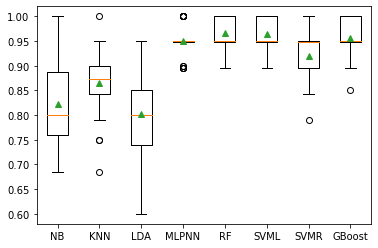

In [8]:
models = get_models()
results = [] ## Store evaluation results
names = []
for name, model in models:
    accuracy = evaluate_models(model, features, labels)
    results.append(accuracy)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(accuracy), std(accuracy)))

plt.boxplot(results, labels=names, showmeans=True)
#plt.savefig('2b_3class_severity_8_MLs_pixels_comparision.pdf')
plt.show()

#### Preprocessing evaluation results

In [9]:
# Build a dataframe including cross validation accuracy for each machine learning methods
df_clf_accuracy = pd.DataFrame(results) # Each fold had 30 datapounts(wavelengths) and we had 10 fold so altogether there were 300 datapoints
df_clf_accuracy = df_clf_accuracy.T # Transpose the dataframe
df_clf_accuracy.columns = names #Name the dataframe columns
df_clf_accuracy
#df_clf_accuracy.to_csv(r'../results/b_2class_severity_8_MLs_pixels_comparisionn_all_clf_accuracy.csv', encoding='utf-8', header='true')

,NB,KNN,LDA,MLPNN,RF,SVML,SVMR,GBoost
0,0.800000,0.900000,0.900000,1.000000,1.000000,1.000000,0.900000,1.000000
1,0.950000,0.900000,0.750000,0.950000,1.000000,0.950000,0.950000,1.000000
2,0.750000,0.900000,0.950000,1.000000,1.000000,1.000000,0.950000,1.000000
3,0.850000,0.750000,0.850000,0.950000,0.950000,0.950000,1.000000,0.850000
4,0.900000,0.900000,0.850000,1.000000,0.950000,1.000000,0.900000,0.950000
5,0.800000,0.950000,0.800000,0.950000,1.000000,0.950000,1.000000,1.000000
6,0.842105,0.894737,0.789474,0.947368,0.947368,0.947368,0.947368,0.947368
7,0.789474,0.842105,0.631579,0.894737,0.947368,0.894737,0.789474,0.947368
8,0.789474,0.842105,0.736842,0.947368,0.947368,0.947368,0.894737,0.947368
9,0.736842,0.684211,0.842105,0.947368,0.894737,0.947368,0.842105,0.947368


###  Post hoc pairwise comparison

#### Prepare dataset for anova and pairwise comparison

In [10]:
df1=df_clf_accuracy # 30*8
df2=df1.stack() #  240*1 folds*methods
df3=df2.reset_index() # Folds*methods*number of methods
method=df3['level_1'] #Methods names as independent (predictor) variable
acc_value=df3.iloc[:,2] #Accuracy value from 3rd column as dependent (response) variable
dfanova=pd.DataFrame(method) #Methods names added to dfnnova df
dfanova['Accuracy']=acc_value #Accuracy value  added to dfnnova df
dfanova.columns=['Method','Accuracy'] # Column names to dfannova df

#### Perform Parametric ANOVA with post hoc tests

In [11]:
lm = sfa.ols('Accuracy ~ C(Method)', data=dfanova).fit() # Fit OLS for method(predictor) and acc_value (response variable)
anova = sa.stats.anova_lm(lm) # Run ANOVA for OLS method
anova # The results tell us that there is a significant difference between groups means (p = 4.093220e-37), but does not tell us the exact group pairs which are different in means.

,df,sum_sq,mean_sq,F,PR(>F)
C(Method),7.0,0.930367,0.132910,39.532749,2.796863e-36
Residual,232.0,0.779987,0.003362,NaN,NaN


#### Perform Post hoc tests (To obtain pairwise differences, carry out a posteriori (post hoc) analysis)
##### Student T test applied pairwisely gives p values

In [12]:
#sp.posthoc_ttest(dfanova, val_col='acc_value', group_col='method')
phoc=sp.posthoc_ttest(dfanova, val_col='Accuracy', group_col='Method') # perform p hoc analysis using Accuracy and Method by applying Student T test pairwisely
remove = np.tril(np.ones(phoc.shape), k=0).astype("bool") #Return a copy of an array with elements above the k-th diagonal zeroed
phoc[remove] = np.nan # remove NAs from phoc
molten_df = phoc.melt(ignore_index=False).reset_index().dropna() #reset the indices and melt/stack the phoc results

### Plot the boxplots to see the pairwise differences

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NB vs. KNN: Custom statistical test, P_val:4.014e-02
KNN vs. LDA: Custom statistical test, P_val:4.207e-03
LDA vs. MLPNN: Custom statistical test, P_val:1.289e-11
MLPNN vs. RF: Custom statistical test, P_val:7.578e-02
RF vs. SVML: Custom statistical test, P_val:8.202e-01
SVML vs. SVMR: Custom statistical test, P_val:1.982e-04
SVMR vs. GBoost: Custom statistical test, P_val:2.586e-03
NB vs. LDA: Custom statistical test, P_val:3.585e-01
KNN vs. MLPNN: Custom statistical test, P_val:8.291e-08
LDA vs. RF: Custom statistical test, P_val:3.068e-13
MLPNN vs. SVML: Custom statistical test, P_val:1.325e-01
RF vs. SVMR: Custom statistical test, P_val:8.045e-05
SVML vs. GBoost: Custom statistical test, P_val:3.771e-01
NB vs. MLPNN: Custom statistical test, P_val:1.176e-10
KNN vs. RF: Custom statistical test, P_val:7.36

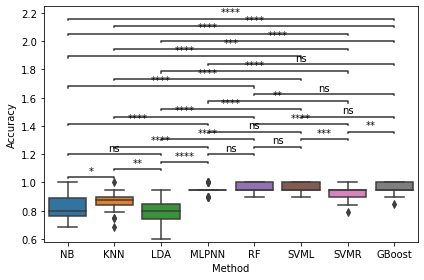

In [13]:
ax=sns.boxplot(data=dfanova, x="Method", y="Accuracy") # Provide the data, and axes for the graph
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()] #store pairs of methods from all methods of molten_df
p_values = [i[1]["value"] for i in molten_df.iterrows()] #storte p_values from molten_df
annotator = Annotator(ax, pairs, data=dfanova, x="Method", y="Accuracy") # provide data to the annotator
annotator.configure(text_format="star", loc="inside") # put star and give the location of the star
annotator.set_pvalues_and_annotate(p_values) #p_values = list or array of p-values for each pair comparison.
#plt.savefig('3b1_2class_severity_pairwise_accuracy_comparison.pdf') # save the plot
plt.tight_layout() # To cover much more space
plt.show()

#### Include pairwise comparison results in the accuracy vs model graph

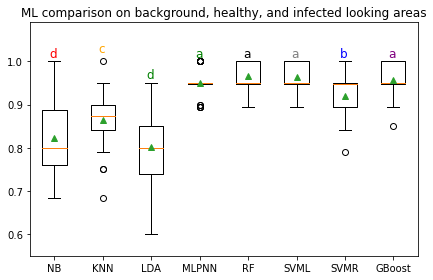

In [14]:
plt.boxplot(results, labels=names, showmeans=True)

plt.text(0.90, 1.01,'d',color='red', fontsize=12)
plt.text(1.9, 1.02,'c',color='orange', fontsize=12)
plt.text(2.9, 0.96,'d',color='green', fontsize=12)
plt.text(3.9, 1.01,'a',color='green', fontsize=12)
plt.text(4.9, 1.01,'a',color='black', fontsize=12)
plt.text(5.9, 1.01,'a',color='grey', fontsize=12)
plt.text(6.9, 1.01,'b',color='blue', fontsize=12)
plt.text(7.9, 1.01,'a',color='purple', fontsize=12)

plt.ylim([0.55, 1.09])
plt.title('ML comparison on background, healthy, and infected looking areas')
plt.tight_layout()
plt.savefig('../Output/Fig3b_3class_severity_8_MLs_pixels_pairwise_accuracy_comparison.pdf')
plt.show()